# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [149]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "../traffic-signs-data/train.p"
validation_file= "../traffic-signs-data/valid.p"
testing_file = "../traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [150]:
import numpy as np
X_train.shape

(34799, 32, 32, 3)

In [151]:
# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# shape of a traffic sign image
image_shape = X_train.shape[1:]

# unique classes/labels are in the dataset.
n_classes = np.unique(np.concatenate((y_train, y_valid, y_test))).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

Min and Max values in the Image are 21 and 200.
Label index is :  18
Label is :  General caution


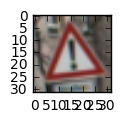

In [152]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
print("Min and Max values in the Image are {} and {}.".format(np.min(image), np.max(image)))
plt.figure(figsize=(1,1))
plt.imshow(image)
# loads signnames.csv as a hashtable and translates label indices
import csv
with open('signnames.csv') as f:
    tbl = dict(filter(None, csv.reader(f)))
label = y_train[index]
print("Label index is : ", label)
print ("Label is : ", tbl[str(label)])

### Conclusion:
Images are 32 X 32 X 3 matrices containing values in the range 0-255. In other words, they're not normalized. Normalizing is the next step. I'm doing it by (R|G|B - 128)/128 - scaling it in the range of -1 to +1. This naturally lends itself to a tanh activation, but I'm sticking with ReLus for now.  

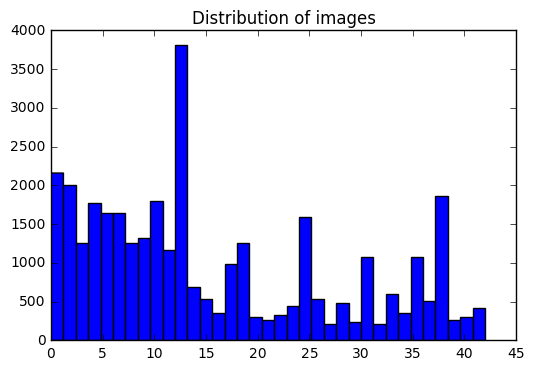

In [153]:
plt.hist(y_train, bins='auto')  
>>> plt.title("Distribution of images")
>>> plt.show()

### Conclusion:
The dataset is not balanced across the labels. In other words, we don't have the same number of images for each sign. This could be a good thing, since perhaps it's showing more frequently occuring road signs, more frequently. However, if future test sets have a markedly differently distribution from our training test, that could work against us. ***Imbalance in the training set causes bias towards labels that have more data.***

### How do we fix this? Data Augmentation
We get more data. Absent getting more real data, we generate synthetic data or do data augmentation through affine transformations of our training set. To quote from Sermanet and LeCun: _"Additionally, we build a jittered dataset by adding 5 transformed versions of the original training set, yielding
126,750 samples in total. Samples are randomly perturbed in
position ([-2,2] pixels), in scale ([.9,1.1] ratio) and rotation
([-15,+15] degrees)."_

#### [From the OpenCV docs](http://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/warp_affine/warp_affine.html):

**Rotate**: To rotate an image, we need to know two things:
- The center with respect to which the image will rotate
- The angle to be rotated. In OpenCV a positive angle is counter-clockwise
- Optional: A scale factor
- eg. rot_mat = getRotationMatrix2D( center, angle, scale );
- Example of a **center** is a 2D point (cols/2, rows/2) in the OpenCV docs. 

In [154]:
from skimage import transform, filters, exposure
import cv2
def augment_image(img,angle_range=(-5, 5),shear_range=10,trans_range=5,brightness=0):
    # rotation
    angle = np.random.uniform(*angle_range)
    rows, cols, _ = img.shape
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1)
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    # Brightness
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    if brightness == 1:
        img = augment_brightness_camera_images(img)
    
    return img.astype(np.uint8)

Image dtype is  uint8
Label index is :  7
Label is :  Speed limit (100km/h)
Image dtype is  uint8
Label index is :  4
Label is :  Speed limit (70km/h)
Image dtype is  uint8
Label index is :  20
Label is :  Dangerous curve to the right
Image dtype is  uint8
Label index is :  1
Label is :  Speed limit (30km/h)


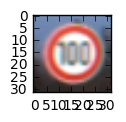

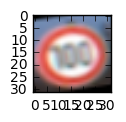

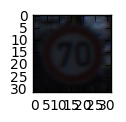

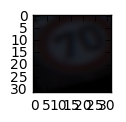

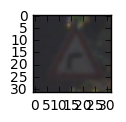

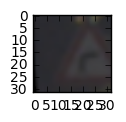

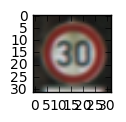

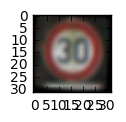

In [155]:
# call k random data points from X_train. Display each original and their augmented versions
import csv
def display_augment_image():
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()
    plt.figure(figsize=(1,1))
    plt.imshow(image)
    
    # augment image
    augment_img = augment_image(image)
    print("Image dtype is ", augment_img.dtype)
    plt.figure(figsize=(1,1))
    plt.imshow(augment_img)
    
    # loads signnames.csv as a hashtable and translates label indices   
    with open('signnames.csv') as f:
        tbl = dict(filter(None, csv.reader(f)))
    label = y_train[index]
    print("Label index is : ", label)
    print ("Label is : ", tbl[str(label)])
    

def test_augment_image_func(N):  
    for _ in range(N):
        display_augment_image() 
        
test_augment_image_func(4)        

### Now we've successfully tested the augment_image function, we'll move onto the actual data augmentation.  

In [156]:
def augment_data(X, y):
    augmented_X = np.zeros([X.shape[0]*6, *X.shape[1:]], dtype = np.uint8)
    augmented_y = np.zeros([y.shape[0]*6, *y.shape[1:]], dtype = np.uint8)
    #print("X dtype : ", X.dtype)
    #print("augmented X dtype : ", augmented_X)
    for i, _ in enumerate(X):
        augmented_X[i] = X[i]
        augmented_y[i] = y[i]
        for j in range(1,6):
            augmented_X[i+j] = augment_image(X[i])
            augmented_y[i+j] = y[i]    
    return augmented_X, augmented_y

In [157]:
X_train, y_train = augment_data(X_train, y_train)

In [158]:
X_train.shape

(208794, 32, 32, 3)

In [159]:
X_train.dtype

dtype('uint8')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

### Normalizing 

In [161]:
def hist_eq(img):
    if (len(img.shape)>3): # if you're passing in a collection of images
        num_images = img.shape[0]
        image_shape = img.shape[1:]
        locEqImg = np.zeros([num_images,image_shape[0],image_shape[1],image_shape[2]])
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(6,6))
        for i in range(num_images):
            #print("currImg dtype is ", img[i].dtype)
            #img[i] =img[i].astype(np.float32)
            currImg = img[i].squeeze()
            #img_yuv = cv2.cvtColor(currImg, cv2.COLOR_RGB2YUV)
            #img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
            #tmp = cv2.cvtColor(img_yuv, cv 2.COLOR_YUV2RGB)
            #eqImg[i]=tmp
            
            img_lab = cv2.cvtColor(currImg, cv2.COLOR_RGB2LAB)
            img_lab[:,:,0]=clahe.apply(img_lab[:,:,0])
            tmp = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
            locEqImg[i] = tmp
    else:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(6,6))
        img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        img_lab[:,:,0]=clahe.apply(img_lab[:,:,0])
        tmp = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
        locEqImg = tmp
    return locEqImg

In [162]:
X_train = hist_eq(X_train)

In [163]:
def normalize(image_dataset):
    return (image_dataset - 128.)/128.

X_train = normalize(X_train)

In [164]:
X_valid = hist_eq(X_valid)

In [165]:
X_valid = normalize(X_valid)

In [166]:
X_test = hist_eq(X_test)

In [167]:
X_test = normalize(X_test)

In [168]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

### Model Architecture

In [170]:
import tensorflow as tf

EPOCHS = 50
BATCH_SIZE = 128


In [175]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Dropout
    conv1 = tf.nn.dropout(conv1, keep_prob)
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Dropout
    conv2 = tf.nn.dropout(conv2, keep_prob)

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43 (for 43 classes).
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [176]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the test set but low accuracy on the validation set implies overfitting.

In [178]:
rate = 0.0005

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [179]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [180]:
# Train the Model

with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer()) #!!! Update tensorflow, but for now can use 
    sess.run(tf.initialize_all_variables())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.8})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.823

EPOCH 2 ...
Validation Accuracy = 0.887

EPOCH 3 ...
Validation Accuracy = 0.912

EPOCH 4 ...
Validation Accuracy = 0.930

EPOCH 5 ...
Validation Accuracy = 0.935

EPOCH 6 ...
Validation Accuracy = 0.939

EPOCH 7 ...
Validation Accuracy = 0.948

EPOCH 8 ...
Validation Accuracy = 0.947

EPOCH 9 ...
Validation Accuracy = 0.951

EPOCH 10 ...
Validation Accuracy = 0.949

EPOCH 11 ...
Validation Accuracy = 0.954

EPOCH 12 ...
Validation Accuracy = 0.958

EPOCH 13 ...
Validation Accuracy = 0.954

EPOCH 14 ...
Validation Accuracy = 0.956

EPOCH 15 ...
Validation Accuracy = 0.957

EPOCH 16 ...
Validation Accuracy = 0.959

EPOCH 17 ...
Validation Accuracy = 0.950

EPOCH 18 ...
Validation Accuracy = 0.954

EPOCH 19 ...
Validation Accuracy = 0.948

EPOCH 20 ...
Validation Accuracy = 0.960

EPOCH 21 ...
Validation Accuracy = 0.955

EPOCH 22 ...
Validation Accuracy = 0.953

EPOCH 23 ...
Validation Accuracy = 0.952

EPOCH 24 ...
Validation Accura

### Running the model on our test set

In [182]:
with tf.Session() as sess:
    saver.restore(sess, './lenet')

    test_accuracy = sess.run(accuracy_operation, feed_dict={x: X_test, y: y_test, keep_prob : 1.0})

print('Test Accuracy: {}'.format(test_accuracy))

Test Accuracy: 0.9609659314155579


# Final Result : Test accuracy is 96.1%

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [230]:
import matplotlib.image as mpimg
def process_newimage(name):
    image = mpimg.imread(name)
    #print ("image type ", type(image))
    #image = cv2.resize(image,(32,32))
    image = hist_eqRGB(image)
    image = normalize(image) 
    return image

### Showing the five test pictures

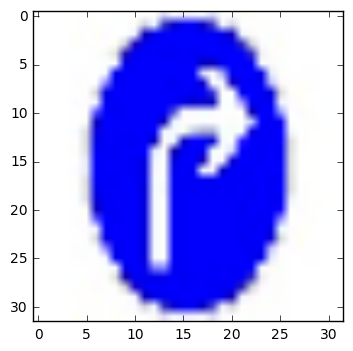

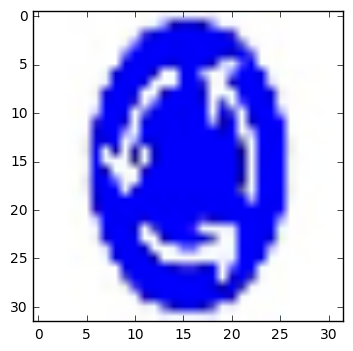

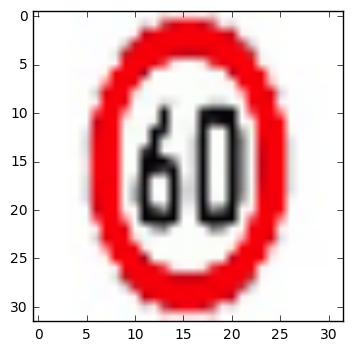

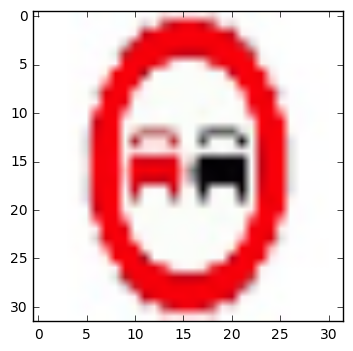

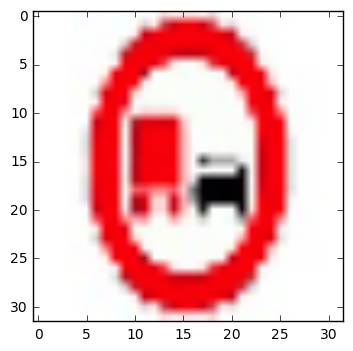

In [236]:
import os
pics = []
path = "five_web_street_signs/"
all_pics = [str(path+f) for f in os.listdir(path) if not f.startswith(".")]

for pic in all_pics:
    image = mpimg.imread(pic)
    plt.imshow(image)  
    plt.show()

### Predict the Sign Type for Each Image

In [245]:
five_test_set = np.array([process_newimage(img_path) for img_path in all_pics])
print(five_test_set.shape)
y_five_test_set = np.array([33,40,3,9,10])

(5, 32, 32, 3)


In [253]:
with tf.Session() as sess:
    saver.restore(sess, './lenet')
    logitz = sess.run(logits, feed_dict={x: five_test_set,keep_prob : 1.0})
    for logit in logitz:
        print(np.argmax(logit))

33
40
3
9
9


### Analyze Performance

In [249]:
with tf.Session() as sess:
    saver.restore(sess, './lenet')

    test_accuracy = sess.run(accuracy_operation, feed_dict={x: five_test_set, y: y_five_test_set, keep_prob : 1.0})

print('Test Accuracy: {}'.format(test_accuracy))


Test Accuracy: 0.800000011920929


## Result: 4 out of the 5 test images are correctly classified. 

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

### My code for softmax scores

In [254]:
with tf.Session() as sess:
    scores = sess.run(tf.nn.top_k(tf.nn.softmax(logitz), k=5, sorted=True))

for i in range(len(scores[0])):
    print('Correct label for image', i, ' is ', y_five_test_set[i], '\n Scores', scores[0][i], 'over labels', scores[1][i])
    print()

Correct label for image 0  is  33 
 Scores [  9.90153730e-01   5.25937835e-03   3.19222314e-03   4.31658846e-04
   3.95357434e-04] over labels [33 35 40 36  5]

Correct label for image 1  is  40 
 Scores [ 0.56382549  0.39744565  0.01431729  0.0053189   0.0052385 ] over labels [40 35 33 37 39]

Correct label for image 2  is  3 
 Scores [  9.99521375e-01   4.12695750e-04   3.68702676e-05   1.64201683e-05
   4.81856978e-06] over labels [3 2 0 5 1]

Correct label for image 3  is  9 
 Scores [  9.99904513e-01   9.41695616e-05   1.24309042e-06   1.60444898e-07
   3.35209904e-08] over labels [ 9 12 25  1 10]

Correct label for image 4  is  10 
 Scores [  5.32121480e-01   4.60766554e-01   6.96455501e-03   1.15243354e-04
   1.77932798e-05] over labels [ 9 10 42 28 12]



### Result
* We have 80% accuracy, but the softmax scores let us examine **_confidence_**. 
    * For the first 4 images, scores for the first or chosen label have a large margin over the 2nd highest score, reflecting high confidence. 
    * The last image (which is the only one mislabeled) has scores that clearly show it quite nearly labeled the image correctly - the incorrect label has a score of 5.32121480e-01 vs 4.60766554e-01 for the correct label. 